Common Google Colab Keyboard shortcuts:

Ctrl + F9: Run all

Ctrl + Enter: Run the selected cell

Ctrl + M B: Create cell below

# Understanding the convolutional neural network

![alt text](https://miro.medium.com/max/1204/1*TVu5hyywTrUsCAkfJbVHQw.png)

1) each layer in a Convolutional Neural Network (CNN) focuses on more fundamental features like edges in earlier layers to more complex features like shapes in the later layers

2) each node in the CNN runs a small subsection (e.g. 3 pixel by 3 pixel subsection) over the entire image and checks how well it matches

3) because the CNN convolves the subsections/nodes with the original data, it is especially well suited for tasks related to images

# Set up the coding environment

In [1]:
# computation dependancies
import torch # used to import data
import torch.nn as nn # used to define neural network
import torch.nn.functional as F # used for activation functions
import numpy as np

# preprocessing dependancies
import torchvision

# visualization dependancies
import matplotlib.pyplot as plt

assert torch.cuda.is_available()
precision = 4
torch.set_printoptions(precision,sci_mode=False) # 4 digits of precision
np.set_printoptions(precision,suppress=True) # 4 digits of precision and suppresses unecessary print output

# Download the dataset online

In [2]:
# downloads data from torchvision dataset
official_mnist_train = torchvision.datasets.MNIST(root = 'HOME/data/mnist', train=True, download=True);
# converts training data into a numpy array with type float32
official_train_images = official_mnist_train.data.numpy().astype(np.float32);
# converts training labels into a numpy array with type int
official_train_labels = official_mnist_train.targets.numpy().astype(np.int);

# Explore the dataset

### How many images are there?

In [3]:
print(f"number of images: {official_train_images.shape[0]} images")

number of images: 60000 images


### How big is each image?

In [4]:
print(f"image width: {official_train_images.shape[1]} pixels \nimage height: {official_train_images.shape[2]} pixels")

image width: 28 pixels 
image height: 28 pixels


### See what the first image looks like using plt.imshow()

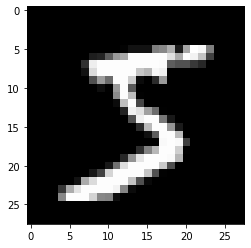

In [5]:
plt.imshow(official_train_images[0],cmap='gray')

### See what the first 10 images look like using plt.imshow() and np.concatenate()

label data:

[5 0 4 1 9 2 1 3 1 4]


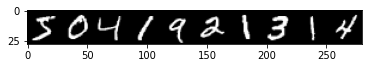

In [6]:
# look at the label data for first 10 entries
print("label data:\n")
example_labels = official_train_labels[:10]
print(example_labels)

# print the first 10 images concatenated horizontally (along column)
example_images = np.concatenate(official_train_images[:10], axis=1)
plt.imshow(example_images,cmap='gray')

# Prepare the data

### Split the data using np.split()

In [7]:
train_images, val_images = np.split(official_train_images, [55000])
train_labels, val_labels = np.split(official_train_labels, [55000])

### Normalizing data by transforming the original data into data with 0 mean and standard deviation of 1

In [8]:
# function to normalize images of shape (num_examples,height,width)
def normalize_images(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / stdev

# prebuilt packages like from sklearn.preprocessing import StandardScaler serve similar function

In [9]:
train_images = normalize_images(train_images)
val_images = normalize_images(val_images)
print(f"mean of data: {np.mean(train_images)} very close to 0")
print(f"standard deviation of data: {np.std(train_images)}...very close to 1")

mean of data: -2.1187847309978025e-10 very close to 0
standard deviation of data: 0.9999994039535522...very close to 1


### Batch processing

In [10]:
def batch(batch_size, training=True):
  """Create a batch of examples.
  
  This creates a batch of input images and a batch of corresponding
  ground-truth labels. We assume CUDA is available (with a GPU).
  
  Args:
    batch_size: An integer.
    training: A boolean. If True, grab examples from the training
      set; otherwise, grab them from the validation set.
  
  Returns:
    A tuple,
    input_batch: A Variable of floats with shape
      [batch_size, 1, height, width]
    label_batch: A Variable of ints with shape
      [batch_size].
  """
  if training:
    random_ind = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    input_batch = train_images[random_ind]
    label_batch = train_labels[random_ind]
  else:
    input_batch = val_images[:batch_size]
    label_batch = val_labels[:batch_size]
  
  input_batch = input_batch[:, np.newaxis, :, :]
  
  volatile = not training
  input_batch = torch.from_numpy(input_batch).cuda()
  label_batch = torch.from_numpy(label_batch).cuda()
  
  return input_batch, label_batch

# Setting up the neural network

In [11]:
class SimpleNN(torch.nn.Module):
  """A Simple Neural Network with 6 convolutional layers and 2 linear layers
  
  Map from inputs with shape [batch_size, 1, height, width] to
  outputs with shape [batch_size, 1].
  """
  
  def __init__(self):
    super().__init__()
    # torch.nn.Conv2d() creates a single convolution layer with
    # (input dimension, output dimension, kernel_size=, padding=) arguments
    self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=7, padding=7//2) # feel free to change these parameters.
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=3//2, stride = 3)
    self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=3//2)
    self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=3//2, stride = 3)
    self.conv5 = torch.nn.Conv2d(128, 128, kernel_size=4, padding = 0, stride = 1)    
    # Final layer maps to 10 outputs which are the 10 classes
    self.conv_final = torch.nn.Conv2d(128, 128, kernel_size=1)
    self.linear1 = torch.nn.Linear(128,128)
    self.linear2 = torch.nn.Linear(128,10)
    for m in self.modules():
      # weight initialization hyperparameters
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            m.reset_parameters()
            torch.nn.init.kaiming_normal_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()

  # defines forward pass with relu activations  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    # output (28 - 7 + 6) / 1 + 1 = 28 x 28 x 32
    x = F.relu(self.conv2(x))
    # output (28 - 3 + 2) / 3 + 1 = 10 x 10 x 32
    x = F.relu(self.conv3(x))
    # output 10 x 10 x 32
    x = F.relu(self.conv4(x))
    # output (10-3+2) / 3 + 1 = 4 x 4 x 32
    x = F.relu(self.conv5(x))
    x = self.conv_final(x)
    x = x.squeeze()
    x = self.linear1(x)
    x = self.linear2(x)
    return x

# Setting up training code

In [12]:
def train_step(batch_size=128):
    # train mode
    model.train()
    # create input and label batches
    input_batch, label_batch = batch(batch_size, training=True)
    # run the inputs through the model and returns outputs
    output_batch = model(input_batch)

    # calculates cross entropy loss
    loss = F.cross_entropy(output_batch, label_batch)
    _, pred_batch = torch.max(output_batch, dim=1)
    # calculates error rate when prediction doesn't match label
    error_rate = 1.0 - (pred_batch == label_batch).float().mean()

    # initiates optimizer
    optimizer.zero_grad()
    # back propagation
    loss.backward()

    # updates model 
    optimizer.step()

    return loss.item(), error_rate.item()

In [13]:
def val():
    # evaluation mode
    model.eval()
    # create input and label batches
    input_batch, label_batch = batch(val_images.shape[0], training=False)
    # run the inputs through the model and returns outputs
    output_batch = model(input_batch)

    # calculates cross entropy loss
    loss = F.cross_entropy(output_batch, label_batch)
    _, pred_batch = torch.max(output_batch, dim=1)
    # calculates error rate when prediction doesn't match label
    error_rate = 1.0 - (pred_batch == label_batch).float().mean()

    return loss.item(), error_rate.item()

### Training the model

In [14]:
# Hyperparameters
batch_size = 128
# validation batch size
val_batch_size = 500
# learning rate
lr = .001


# instantiates neural network model
model = SimpleNN()
model.cuda()
# uses Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# code to display status of training through text
info = []
# number of steps is the number of times batch training happens
num_steps = 2000
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  if step % num_steps_per_val == 0:
    val_loss, val_err = val()
    # updates validation error when more accurate output is returned by the model
    if val_err < best_val_err:
      best_val_err = val_err
      print('Step {:5d}: Obtained a best validation error of {:.4f}.'.format(step, best_val_err))
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)


Step     0: Obtained a best validation error of 0.8008.
Step    50: Obtained a best validation error of 0.0528.
Step   100: Obtained a best validation error of 0.0308.
Step   150: Obtained a best validation error of 0.0268.
Step   200: Obtained a best validation error of 0.0216.
Step   350: Obtained a best validation error of 0.0208.
Step   400: Obtained a best validation error of 0.0192.
Step   600: Obtained a best validation error of 0.0176.
Step   650: Obtained a best validation error of 0.0146.
Step   850: Obtained a best validation error of 0.0138.
Step  1200: Obtained a best validation error of 0.0098.


### plots cross entropy loss and error rate

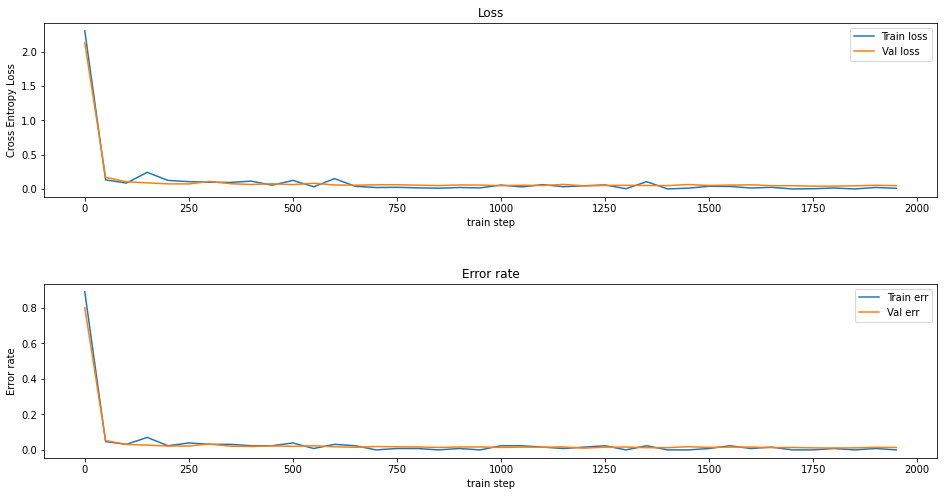

In [15]:
fig, axs = plt.subplots(2,1,figsize=(16,8))
fig.subplots_adjust(hspace = 0.5)
axs[0].plot(x, y11, x, y12)
axs[0].set_title('Loss')
axs[0].set_ylabel('Cross Entropy Loss')
axs[0].set_xlabel('train step')
axs[0].legend(['Train loss', 'Val loss'])
axs[1].plot(x, y21, x, y22)
axs[1].set_title('Error rate')
axs[1].set_ylabel('Error rate')
axs[1].set_xlabel('train step')
axs[1].legend(['Train err', 'Val err'])

# Testing out the trained model

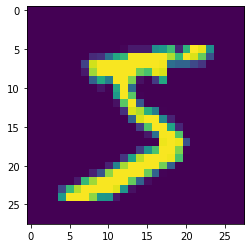

In [16]:
plt.imshow(train_images[0])

### lets use our trained model to predict what the image above is

In [17]:
output = model(torch.reshape(torch.from_numpy(train_images[0]).cuda(), (1,1,28,28)))
pred = torch.max(output, dim=0)
print(f"model predicts a {pred.indices}")
  

model predicts a 5
